CODE BLOCK: 1

In [10]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [1]:
import sys
sys.path.insert(0,"/content/drive/MyDrive/ERA/Session_8")

In [2]:
from utils import *
from models import *

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary

CODE BLOCK: 2

In [4]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

CUDA Available? True
cuda


CODE BLOCK: 3

In [5]:
# # Train data transformations
# train_transforms = transforms.Compose([
#     transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
#     transforms.Resize((28, 28)),
#     transforms.RandomRotation((-15., 15.), fill=0),
#     transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,)),
#     ])

# # Test data transformations
# test_transforms = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,))
#     ])

train_transforms = transforms.Compose(
    [transforms.ToTensor(),
    #  transforms.Normalize((0.4915, 0.4823, 0.4468),(0.2470, 0.2435, 0.2616))
     ])

test_transforms = transforms.Compose(
    [transforms.ToTensor(),
    #  transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))
     ])



CODE BLOCK: 4

In [6]:
# train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
# test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)
train_data = datasets.CIFAR10('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.CIFAR10('../data', train=False, download=True, transform=test_transforms)
# train_data = datasets.CIFAR10('../data', train=True, download=True)
# test_data = datasets.CIFAR10('../data', train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


CODE BLOCK: 5

In [7]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(train_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

CODE BLOCK: 6

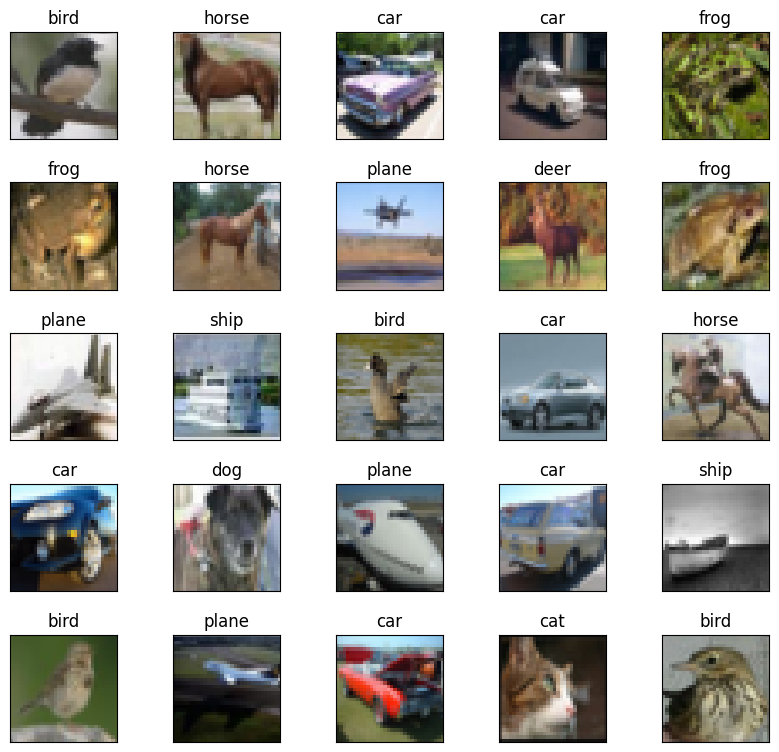

In [8]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))
plot_samples_cifar10(batch_data,batch_label,classes)


In [10]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = cifar_model_bn().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
            Conv2d-4           [-1, 32, 32, 32]           4,640
              ReLU-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
            Conv2d-7           [-1, 16, 32, 32]             528
         MaxPool2d-8           [-1, 16, 16, 16]               0
            Conv2d-9           [-1, 24, 16, 16]           3,480
             ReLU-10           [-1, 24, 16, 16]               0
      BatchNorm2d-11           [-1, 24, 16, 16]              48
           Conv2d-12           [-1, 32, 16, 16]           6,944
             ReLU-13           [-1, 32, 16, 16]               0
      BatchNorm2d-14           [-1, 32,

CODE BLOCK: 8

In [11]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [12]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = F.nll_loss(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            # test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss
            # loss_fn = nn.CrossEntropyLoss(reduction='sum')
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 10

In [13]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1, verbose=True)
# New Line
# criterion = nn.CrossEntropyLoss()
num_epochs = 15

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer)
  test(model, device, test_loader)
  # scheduler.step()

Epoch 1


Train: Loss=1.4531 Batch_id=97 Accuracy=34.86: 100%|██████████| 98/98 [00:09<00:00,  9.88it/s]


Test set: Average loss: 1.5290, Accuracy: 21603/50000 (43.21%)

Epoch 2


Train: Loss=1.1012 Batch_id=97 Accuracy=52.17: 100%|██████████| 98/98 [00:11<00:00,  8.38it/s]


Test set: Average loss: 1.4810, Accuracy: 23381/50000 (46.76%)

Epoch 3


Train: Loss=1.0398 Batch_id=97 Accuracy=60.48: 100%|██████████| 98/98 [00:10<00:00,  9.75it/s]


Test set: Average loss: 1.1478, Accuracy: 29332/50000 (58.66%)

Epoch 4


Train: Loss=0.9183 Batch_id=97 Accuracy=64.72: 100%|██████████| 98/98 [00:09<00:00, 10.25it/s]


Test set: Average loss: 0.9612, Accuracy: 32667/50000 (65.33%)

Epoch 5


Train: Loss=0.8998 Batch_id=97 Accuracy=67.58: 100%|██████████| 98/98 [00:10<00:00,  9.54it/s]


Test set: Average loss: 0.9697, Accuracy: 32815/50000 (65.63%)

Epoch 6


Train: Loss=0.8333 Batch_id=97 Accuracy=70.05: 100%|██████████| 98/98 [00:10<00:00,  9.57it/s]


Test set: Average loss: 0.9560, Accuracy: 32954/50000 (65.91%)

Epoch 7


Train: Loss=0.7867 Batch_id=97 Accuracy=72.35: 100%|██████████| 98/98 [00:09<00:00, 10.05it/s]


Test set: Average loss: 0.7948, Accuracy: 35632/50000 (71.26%)

Epoch 8


Train: Loss=0.8010 Batch_id=97 Accuracy=73.52: 100%|██████████| 98/98 [00:10<00:00,  9.55it/s]


Test set: Average loss: 0.8287, Accuracy: 35454/50000 (70.91%)

Epoch 9


Train: Loss=0.7333 Batch_id=97 Accuracy=75.06: 100%|██████████| 98/98 [00:10<00:00,  9.03it/s]


Test set: Average loss: 0.7460, Accuracy: 36724/50000 (73.45%)

Epoch 10


Train: Loss=0.6706 Batch_id=97 Accuracy=76.27: 100%|██████████| 98/98 [00:09<00:00, 10.74it/s]


Test set: Average loss: 0.7431, Accuracy: 36898/50000 (73.80%)

Epoch 11


Train: Loss=0.5919 Batch_id=97 Accuracy=77.25: 100%|██████████| 98/98 [00:10<00:00,  9.53it/s]


Test set: Average loss: 0.7602, Accuracy: 36739/50000 (73.48%)

Epoch 12


Train: Loss=0.6587 Batch_id=97 Accuracy=78.26: 100%|██████████| 98/98 [00:10<00:00,  9.47it/s]


Test set: Average loss: 0.6340, Accuracy: 38967/50000 (77.93%)

Epoch 13


Train: Loss=0.6591 Batch_id=97 Accuracy=79.50: 100%|██████████| 98/98 [00:08<00:00, 11.21it/s]


Test set: Average loss: 0.6493, Accuracy: 38529/50000 (77.06%)

Epoch 14


Train: Loss=0.5672 Batch_id=97 Accuracy=80.36: 100%|██████████| 98/98 [00:10<00:00,  9.51it/s]


Test set: Average loss: 0.6844, Accuracy: 37892/50000 (75.78%)

Epoch 15


Train: Loss=0.4639 Batch_id=97 Accuracy=81.14: 100%|██████████| 98/98 [00:10<00:00,  9.42it/s]


Test set: Average loss: 0.5576, Accuracy: 40221/50000 (80.44%)



CODE BLOCK: 11

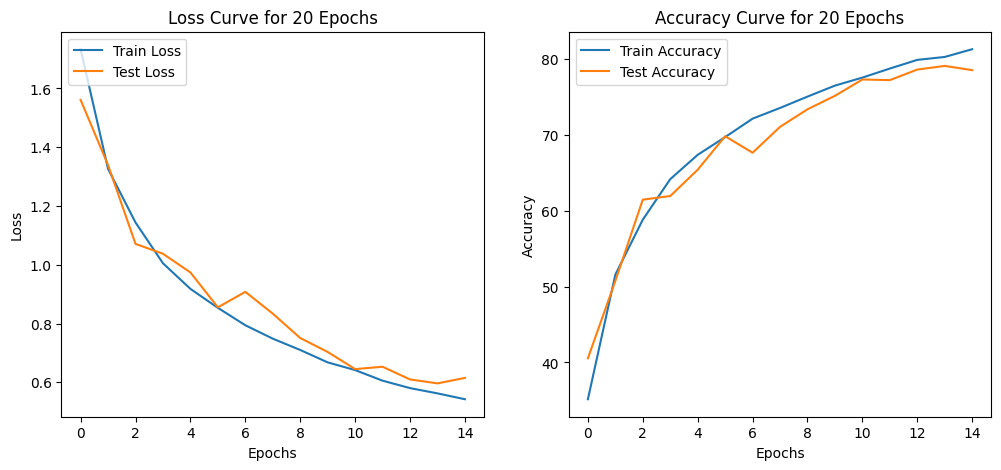

In [ ]:
plot_accuracy_metrics(train_losses,train_acc,test_losses,test_acc)

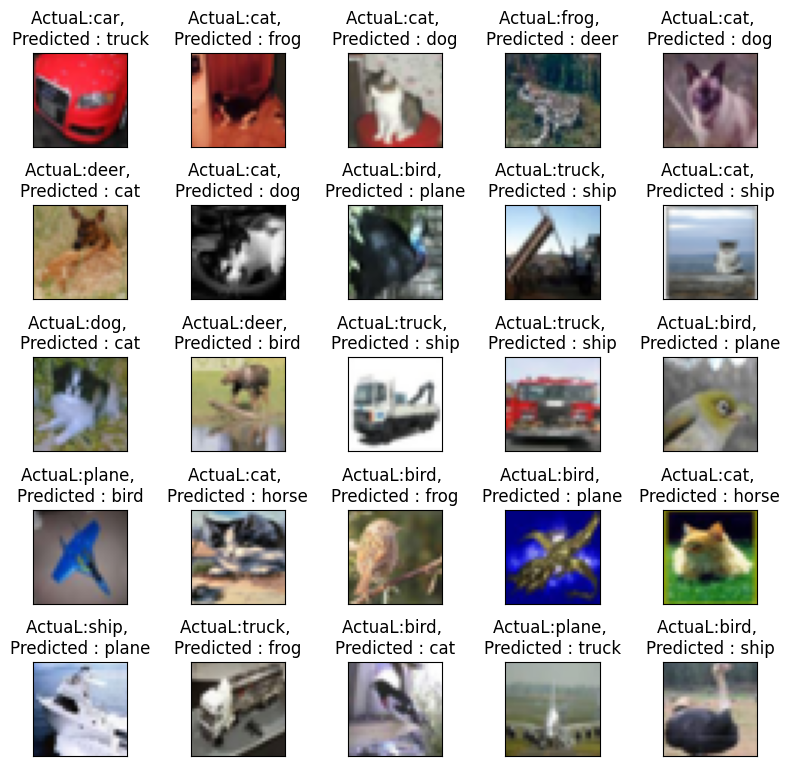

In [14]:
# Show Misclassified images
for batch_idx, (data, target) in enumerate(test_loader):
  data, target = data.to(device), target.to(device)
  output = model(data)
  output_label = output.argmax(dim=1)
  op_ne_target = output.argmax(dim=1).ne(target)
  actual_label = target[op_ne_target].to('cpu')
  predicted_label = output_label[op_ne_target].to('cpu')
  images = data[op_ne_target].to('cpu')
  plot_misclassified_samples(images, actual_label, predicted_label,classes)
  break
